In [1]:
import pandas as pd
import numpy as np

In [2]:
import plotly_express as px
import seaborn as sns

/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
OHCO = ['doc_id','sent_num','token_num']
BAG = OHCO[:1] # document 

#### Full dataset

In [11]:
LIB = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/LIB.csv').set_index('doc_id')
DOC = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/DOC.csv').set_index(['doc_id','sent_num'])
TOKEN = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/TOKEN.csv').set_index(OHCO)
VOCAB = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/VOCAB.csv').set_index('term_id')

##### 2000 sampled dataset

In [8]:
LIB_samp = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/LIB_samp.csv').set_index('doc_id')
DOC_samp = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/DOC_samp.csv').set_index(['doc_id','sent_num'])
TOKEN_samp = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/TOKEN_samp.csv').set_index(OHCO)
VOCAB_samp = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/VOCAB_samp.csv').set_index('term_id')

## TFIDF

In [6]:
def TFIDF(token, bag, tf_method, idf_method, count_method, count_item):
    TOKEN = token
    TOKEN = TOKEN[~TOKEN.term_str.isna()]
    TOKEN['stem_porter'] = TOKEN.term_id.map(VOCAB_samp.stem_porter)
    
    if count_item == 'term':
        print('term')
        BOW = TOKEN.groupby(bag+['term_id']).term_id.count().to_frame().rename(columns={'term_id':'n'})
        BOW['c'] = BOW.n.astype('bool').astype('int')
        
    else: #stem
        BOW = TOKEN.groupby(bag+['stem_porter']).stem_porter.count().to_frame().rename(columns={'stem_porter':'n'})
        BOW['c'] = BOW.n.astype('bool').astype('int')
    
    DTCM = BOW[count_method].unstack().fillna(0).astype('int')
    print('dtcm')
    if tf_method == 'sum':
        print('sum')
        TF = DTCM.T / DTCM.T.sum()

    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()

    elif tf_method == 'log':
        TF = np.log10(1 + DTCM.T)

    elif tf_method == 'raw':
        TF = DTCM.T

    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = 0.5 + (1 - 0.5) * TF[TF > 0] #switched tf_norm_k out as 0.5

    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
        
    print('done sum')
    TF = TF.T
    print('tf')

    DF = DTCM[DTCM > 0].count()
    print('idf')
    # compute IDF
    N = DTCM.shape[0]
    if idf_method == 'standard':
        print('standard')
        IDF = np.log10(N / DF)

    elif idf_method == 'max':
        IDF = np.log10(DF.max() / DF) 

    elif idf_method == 'smooth':
        IDF = np.log10((1 + N) / (1 + DF))

    print('multiply')
    TFIDF = TF * IDF
    print('BOW')
    BOW['tf'] = TF.stack()
    BOW['tfidf'] = TFIDF.stack()

    return TFIDF, DF, IDF, BOW

In [7]:
TFIDF, DF, IDF, BOW=TFIDF(TOKEN_samp, BAG, 'sum', 'standard', 'n', 'term')
TFIDF.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



term
dtcm
sum
done sum
tf
idf
standard
multiply
BOW


term_id,0,1,2,3,4,5,6,7,8,9,...,36893,36894,36895,36896,36897,36898,36899,36900,36901,36902
doc_id,,,,,,,,,,,,,,,,,,,,,
49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
TFIDF.to_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/TFIDF_samp.csv')
BOW.to_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/BOW_samp.csv')

In [5]:
# TFIDF = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/TFIDF_samp.csv').set_index('doc_id')
# BOW =  pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/BOW_samp.csv').set_index(['doc_id','term_id'])

In [22]:
# IDF = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/IDF_samp.csv').set_index('term_id')
# DF = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/DF_samp.csv').set_index('term_id')

In [62]:
# VOCAB_tfidf = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/VOCAB_TFIDF.csv')

### TOP 5000 significant TFIDF

In [11]:
VOCAB_samp['df'] = DF
VOCAB_samp['idf'] = IDF
VOCAB_samp['tfidf_sum'] = TFIDF.sum()

In [12]:
tfidf = TFIDF.copy()

In [18]:
VOCAB_tfidf = VOCAB_samp.copy()
VOCAB_tfidf

,term_str,n,num,stop,stem_porter,stem_snowball,stem_lancaster,pos_max,df,idf,tfidf_sum
term_id,,,,,,,,,,,
0,0,4,1,0,0,0,0,CD,3.0,2.823909,0.023876
1,00,1,1,0,00,00,00,JJ,1.0,3.301030,0.004534
2,0000,67,1,0,0000,0000,0000,NNP,23.0,1.939302,0.389220
3,00006,2,1,0,00006,00006,00006,CD,1.0,3.301030,0.007091
4,0019,1,1,0,0019,0019,0019,CD,1.0,3.301030,0.007352
...,...,...,...,...,...,...,...,...,...,...,...
36898,گروههای,1,0,0,گروههای,گروههای,گروههای,NNP,1.0,3.301030,0.010967
36899,گزارش,1,0,0,گزارش,گزارش,گزارش,NNP,1.0,3.301030,0.010967
36900,ی,1,0,0,ی,ی,ی,NNP,1.0,3.301030,0.010967


In [16]:
# tfidf.columns.names = ['term_id']
# tfidf

In [19]:
tfidf_top = VOCAB_tfidf.tfidf_sum.nlargest(5000)

In [20]:
top_list = list(tfidf_top.index)

In [21]:
len(TFIDF)

2000

In [22]:
tfidf = tfidf.loc[:,tfidf.columns.isin(top_list)]
tfidf

term_id,2,18,19,20,21,22,23,80,132,164,...,36685,36686,36689,36691,36693,36698,36745,36787,36798,36816
doc_id,,,,,,,,,,,,,,,,,,,,,
49,0.0,0.0,0.003401,0.0,0.0,0.0,0.0,0.0,0.003757,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.006576,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.005014,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
432,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1410,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023311,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1024310,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1024562,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## PCA on Reduced TFIDF

In [23]:
tfidf = tfidf.apply(lambda x: x / np.sqrt(np.square(x).sum()), 1)

In [24]:
tfidf = tfidf - tfidf.mean()

In [25]:
COV = tfidf.T.dot(tfidf) / (tfidf.shape[0] - 1)

In [26]:
COV.head()

term_id,2,18,19,20,21,22,23,80,132,164,...,36685,36686,36689,36691,36693,36698,36745,36787,36798,36816
term_id,,,,,,,,,,,,,,,,,,,,,
2,4.791188e-04,-6.372453e-07,-3.163702e-07,-0.000005,-1.809571e-06,-1.126360e-06,-0.000002,7.501181e-05,0.000063,-3.388610e-06,...,-1.701565e-06,-8.204758e-07,-8.382386e-06,-2.087355e-06,-0.000002,-6.753701e-06,-8.035313e-07,-2.693747e-06,7.935317e-06,-1.208073e-06
18,-6.372453e-07,2.247641e-04,2.238466e-05,0.000001,6.897072e-06,2.561246e-07,0.000006,3.223885e-06,0.000002,-6.048897e-07,...,-2.204340e-06,-1.736671e-06,-6.327504e-06,-4.180638e-06,-0.000002,-1.603661e-06,-1.700805e-06,-9.138921e-07,-1.241918e-06,4.293494e-06
19,-3.163702e-07,2.238466e-05,2.240977e-04,0.000005,-4.567615e-07,5.599222e-06,0.000001,3.466936e-06,0.000016,8.693530e-06,...,-2.701891e-06,-1.417088e-06,5.832683e-06,-3.605184e-06,-0.000003,9.753124e-07,-1.387822e-06,1.360542e-05,6.129912e-06,-2.086529e-06
20,-4.690449e-06,1.249713e-06,5.095182e-06,0.000210,5.124570e-06,6.899126e-06,0.000001,2.473341e-06,-0.000006,-1.808105e-06,...,4.304010e-07,3.698836e-09,4.390334e-06,-6.792388e-07,-0.000002,5.104333e-06,-1.049597e-06,5.497742e-06,-1.809995e-06,-1.578022e-06
21,-1.809571e-06,6.897072e-06,-4.567615e-07,0.000005,1.151116e-04,7.541593e-08,0.000020,4.196527e-07,0.000006,-1.230042e-06,...,-8.574907e-07,-4.134724e-07,5.296812e-07,-1.051907e-06,-0.000001,-4.696949e-07,-4.049334e-07,7.414173e-07,-6.982941e-07,-6.087993e-07


In [27]:
from scipy.linalg import eigh 

In [28]:
eig_vals, eig_vecs = eigh(COV)

In [29]:
TERM_IDX = COV.index

In [30]:
EIG_VEC = pd.DataFrame(eig_vecs, index=TERM_IDX, columns=TERM_IDX)

In [31]:
EIG_VAL = pd.DataFrame(eig_vals, index=TERM_IDX, columns=['eig_val'])
EIG_VAL.index.name = 'term_id'

In [32]:
EIG_VEC.iloc[:5, :10].style.background_gradient()

term_id,2,18,19,20,21,22,23,80,132,164
term_id,,,,,,,,,,
2,0.004350,-0.003071,-0.019308,0.035054,-0.041607,-0.028639,0.057311,-0.079388,0.128261,-0.103240
18,0.009929,0.006144,-0.009900,0.040027,-0.026853,0.007073,0.031143,-0.045262,0.046791,-0.046792
19,0.019940,0.014961,-0.030577,-0.017823,-0.008030,0.027206,0.018499,-0.022576,0.062413,-0.045582
20,-0.007755,0.015845,-0.011542,0.053225,0.004997,-0.030929,0.049289,0.013146,0.038363,-0.024202
21,0.032948,0.019397,-0.020276,0.000119,-0.015557,-0.001469,-0.035862,-0.048988,0.103359,0.003807


In [33]:
EIG_VAL.iloc[:5]

,eig_val
term_id,
2,-4.266256e-18
18,-3.877806e-18
19,-3.711596e-18
20,-3.672049e-18
21,-3.530491e-18


In [34]:
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

In [35]:
EIG_PAIRS.head() #term id as component. each row is components

,eig_val,2,18,19,20,21,22,23,80,132,...,36685,36686,36689,36691,36693,36698,36745,36787,36798,36816
term_id,,,,,,,,,,,,,,,,,,,,,
2,-4.266256e-18,0.004350,0.009929,0.019940,-0.007755,0.032948,0.001064,-0.012749,0.008773,0.007715,...,0.000143,0.004046,-0.003573,-0.005401,-0.006843,0.005004,-0.014293,0.001960,0.005329,0.009080
18,-3.877806e-18,-0.003071,0.006144,0.014961,0.015845,0.019397,0.000239,-0.000034,0.005010,-0.014540,...,-0.005618,0.004983,-0.000723,0.008516,0.014626,0.001548,-0.012382,0.018254,-0.002872,0.005015
19,-3.711596e-18,-0.019308,-0.009900,-0.030577,-0.011542,-0.020276,0.023314,-0.031421,-0.000025,0.022641,...,-0.004436,0.005716,-0.008865,0.012062,0.005586,0.005835,0.002238,-0.003015,0.003191,0.001904
20,-3.672049e-18,0.035054,0.040027,-0.017823,0.053225,0.000119,0.031798,0.000393,0.007199,0.005202,...,-0.006100,-0.010844,-0.002650,-0.012065,0.009287,0.013351,-0.000063,-0.002384,-0.005616,0.002546
21,-3.530491e-18,-0.041607,-0.026853,-0.008030,0.004997,-0.015557,0.006125,-0.019151,-0.003978,0.012998,...,-0.008848,-0.006897,0.011998,0.011421,0.010243,0.024219,-0.002303,0.011720,-0.024281,0.004528


In [36]:
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

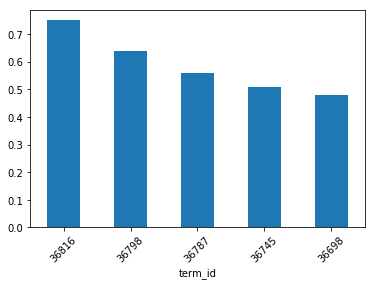

In [37]:
EIG_PAIRS.exp_var.sort_values(ascending=False).head().plot.bar(rot=45) #first three component might be interesting!

In [38]:
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]

In [39]:
COMPS

,eig_val,2,18,19,20,21,22,23,80,132,...,36686,36689,36691,36693,36698,36745,36787,36798,36816,exp_var
PC0,0.007195,-0.000424,-0.009412,-0.016060,-0.005267,-0.004075,-0.002671,-0.002332,-0.002351,-0.005233,...,-0.002077,-0.027354,-0.003278,-0.005321,-0.012206,0.003284,0.000207,-0.002579,0.001382,0.75
PC1,0.006183,-0.006277,-0.010680,-0.002392,-0.002815,0.001620,0.000081,0.002482,-0.004339,-0.005881,...,0.003039,-0.007637,0.002952,0.006552,0.005858,0.001314,-0.002536,-0.000839,0.001093,0.64
PC2,0.005415,-0.007106,-0.000345,0.006262,0.014864,0.001907,0.003241,0.004385,0.007864,0.006262,...,0.000615,0.096171,0.012940,-0.003309,0.090615,-0.003126,0.004886,-0.002882,0.000103,0.56
PC3,0.004970,-0.007385,0.007145,-0.003188,-0.007045,-0.002642,0.001922,-0.002598,-0.011115,-0.003375,...,-0.000625,0.033987,0.003033,-0.004232,0.010864,0.000095,-0.000301,-0.005255,-0.002173,0.51
PC4,0.004603,0.004421,0.000632,0.003523,-0.006746,0.000776,-0.000149,-0.001162,-0.008493,-0.001103,...,-0.000431,0.021100,-0.002159,-0.007590,-0.003375,-0.000080,-0.004756,0.000584,-0.002704,0.48
PC5,0.004253,0.016332,0.002441,-0.001454,-0.004981,-0.007472,0.000403,-0.004510,-0.006889,0.000513,...,-0.000353,0.046632,0.005385,-0.012992,0.056817,-0.001912,-0.004008,-0.001439,-0.000206,0.44
PC6,0.004088,-0.020360,0.003710,0.007842,0.003377,0.001627,-0.000228,0.002549,-0.013214,-0.003338,...,0.005309,0.002752,0.001666,0.013191,-0.004329,-0.003626,-0.003758,-0.003062,-0.004931,0.42
PC7,0.003941,0.001736,0.002786,0.000513,-0.005290,0.000119,-0.002551,0.001618,0.006891,-0.005778,...,-0.000914,0.006426,-0.000258,-0.000655,0.016055,0.000589,-0.005061,-0.002849,0.004826,0.41
PC8,0.003807,0.002807,0.000252,-0.012002,-0.000157,-0.002409,0.002568,0.003965,0.004260,-0.008481,...,-0.000237,0.070315,0.002651,0.003323,0.091258,-0.005040,-0.006186,-0.004006,0.002951,0.39
PC9,0.003647,-0.031298,-0.006791,-0.013412,-0.005558,-0.003030,-0.006031,-0.002230,-0.005840,-0.017527,...,0.002989,-0.038042,0.002935,0.008032,-0.104874,0.003097,-0.004489,-0.007565,0.000285,0.38


In [40]:
LOADINGS = COMPS[TERM_IDX].T
LOADINGS.index.name = 'term_id'

In [41]:
LOADINGS.head().style.background_gradient()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
term_id,,,,,,,,,,
2,-0.000424,-0.006277,-0.007106,-0.007385,0.004421,0.016332,-0.020360,0.001736,0.002807,-0.031298
18,-0.009412,-0.010680,-0.000345,0.007145,0.000632,0.002441,0.003710,0.002786,0.000252,-0.006791
19,-0.016060,-0.002392,0.006262,-0.003188,0.003523,-0.001454,0.007842,0.000513,-0.012002,-0.013412
20,-0.005267,-0.002815,0.014864,-0.007045,-0.006746,-0.004981,0.003377,-0.005290,-0.000157,-0.005558
21,-0.004075,0.001620,0.001907,-0.002642,0.000776,-0.007472,0.001627,0.000119,-0.002409,-0.003030


In [43]:
LOADINGS['term_str'] = LOADINGS.apply(lambda x: VOCAB_tfidf.loc[int(x.name)].term_str, 1)

In [44]:
l0_pos = LOADINGS.sort_values('PC0', ascending=True).head(10).term_str.str.cat(sep=' ') #words associate with positive value
l0_neg = LOADINGS.sort_values('PC0', ascending=False).head(10).term_str.str.cat(sep=' ') #with negative value
l1_pos = LOADINGS.sort_values('PC1', ascending=True).head(10).term_str.str.cat(sep=' ')
l1_neg = LOADINGS.sort_values('PC1', ascending=False).head(10).term_str.str.cat(sep=' ')

In [45]:
print('docs PC0+', l0_pos)
print('docs PC0-', l0_neg)
print('docs PC1+', l1_pos)
print('docs PC1-', l1_neg)

docs PC0+ health insurance bill obamacare care republicans tax repeal medicaid percent
docs PC0- comey fbi russia investigation russian intelligence flynn mueller dossier clinton
docs PC1+ comey republicans senate trump health obamacare bill insurance fbi care
docs PC1- omar her she ilhan ellison minnesota i jensorensen video http


In [46]:
DCM = tfidf.dot(COMPS[TERM_IDX].T)

In [47]:
DCM #every document has distribution of component

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
doc_id,,,,,,,,,,
49,-0.093166,-0.086932,0.042850,-0.019726,0.064670,-0.064595,0.042776,0.008602,-0.007230,0.048177
106,-0.141886,-0.085560,0.074512,-0.025213,0.138597,-0.062030,0.053243,-0.015268,0.007237,0.015282
135,-0.066061,0.002858,-0.075726,0.025272,-0.016114,0.057892,-0.039697,-0.049269,-0.054280,-0.099244
432,0.012025,0.215684,-0.039914,0.088374,0.264253,0.191914,0.101285,0.446887,-0.345596,-0.031290
1410,-0.058337,0.003940,0.025181,0.039363,0.001166,-0.033147,0.006692,-0.034898,-0.045998,0.073506
...,...,...,...,...,...,...,...,...,...,...
1023311,-0.057692,-0.002543,-0.019031,0.050340,-0.020944,0.048793,-0.035260,-0.057694,-0.102446,0.033370
1024310,0.005206,0.053200,0.017994,0.024285,-0.013741,0.066422,-0.013057,-0.000062,-0.040944,0.009023
1024562,-0.043406,0.024095,-0.015772,-0.083025,-0.035000,-0.110201,0.074773,-0.008071,-0.007060,0.016576


In [50]:
LIB_samp

,year,month,year_month,doc_title,doc_source
doc_id,,,,,
49,2013,11,2013-11,NY Times Editorial Board Hacked by The Onion,PowerLine
106,2013,11,2013-11,Putting 'rate shock' into perspective,Daily Kos
135,2013,11,2013-11,Daily Kos Elections Morning Digest: Minnesota ...,Daily Kos
432,2013,11,2013-11,Lies of Obamacare: Cancel this,PowerLine
1410,2013,11,2013-11,Elizabeth Warren joins expand Social Security ...,Daily Kos
...,...,...,...,...,...
1023311,2020,2,2020-02,Bernie All the Way? [Updated],PowerLine
1024310,2020,2,2020-02,"Bernie Sanders, 60 Minutes style",PowerLine
1024562,2020,2,2020-02,Good News On Immigration,PowerLine


In [52]:
DCM = DCM.join(LIB_samp[['year','doc_source','month']], on='doc_id') 

In [53]:
DCM

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,year,doc_source,month
doc_id,,,,,,,,,,,,,
49,-0.093166,-0.086932,0.042850,-0.019726,0.064670,-0.064595,0.042776,0.008602,-0.007230,0.048177,2013,PowerLine,11
106,-0.141886,-0.085560,0.074512,-0.025213,0.138597,-0.062030,0.053243,-0.015268,0.007237,0.015282,2013,Daily Kos,11
135,-0.066061,0.002858,-0.075726,0.025272,-0.016114,0.057892,-0.039697,-0.049269,-0.054280,-0.099244,2013,Daily Kos,11
432,0.012025,0.215684,-0.039914,0.088374,0.264253,0.191914,0.101285,0.446887,-0.345596,-0.031290,2013,PowerLine,11
1410,-0.058337,0.003940,0.025181,0.039363,0.001166,-0.033147,0.006692,-0.034898,-0.045998,0.073506,2013,Daily Kos,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023311,-0.057692,-0.002543,-0.019031,0.050340,-0.020944,0.048793,-0.035260,-0.057694,-0.102446,0.033370,2020,PowerLine,2
1024310,0.005206,0.053200,0.017994,0.024285,-0.013741,0.066422,-0.013057,-0.000062,-0.040944,0.009023,2020,PowerLine,2
1024562,-0.043406,0.024095,-0.015772,-0.083025,-0.035000,-0.110201,0.074773,-0.008071,-0.007060,0.016576,2020,PowerLine,2


In [54]:
DCM['doc'] = DCM.apply(lambda x: "{}-{}".format(str(x.year), x.doc_source), 1)

In [55]:
DCM.doc.iloc[1]

'2013-Daily Kos'

In [56]:
DCM.head().style.background_gradient()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,year,doc_source,month,doc
doc_id,,,,,,,,,,,,,,
49,-0.093166,-0.086932,0.042850,-0.019726,0.064670,-0.064595,0.042776,0.008602,-0.007230,0.048177,2013,PowerLine,11,2013-PowerLine
106,-0.141886,-0.085560,0.074512,-0.025213,0.138597,-0.062030,0.053243,-0.015268,0.007237,0.015282,2013,Daily Kos,11,2013-Daily Kos
135,-0.066061,0.002858,-0.075726,0.025272,-0.016114,0.057892,-0.039697,-0.049269,-0.054280,-0.099244,2013,Daily Kos,11,2013-Daily Kos
432,0.012025,0.215684,-0.039914,0.088374,0.264253,0.191914,0.101285,0.446887,-0.345596,-0.031290,2013,PowerLine,11,2013-PowerLine
1410,-0.058337,0.003940,0.025181,0.039363,0.001166,-0.033147,0.006692,-0.034898,-0.045998,0.073506,2013,Daily Kos,11,2013-Daily Kos


In [57]:
def vis_pcs_source(M, a, b, label='doc_source', prefix='PC'):
    fig = px.scatter(M, prefix + str(a), prefix + str(b), 
                        color=label, 
                        hover_name='doc', marginal_x='box')
    fig.show()

In [58]:
def vis_pcs_year(M, a, b, label='year', prefix='PC'):
    fig = px.scatter(M, prefix + str(a), prefix + str(b), 
                        color=label, 
                        hover_name='doc', marginal_x='box')
    fig.show()

In [59]:
def vis_pcs_month(M, a, b, label='month', prefix='PC'):
    fig = px.scatter(M, prefix + str(a), prefix + str(b), 
                        color=label, 
                        hover_name='doc', marginal_x='box')
    fig.show()

In [74]:
vis_pcs_source(DCM, 0, 1)
#fig_pca1.write_html("/home/yk4we/ETA_final/fig_pca1.html")

In [75]:
print('docs PC0+', l0_pos)
print('docs PC0-', l0_neg)
print('docs PC1+', l1_pos)
print('docs PC1-', l1_neg)

docs PC0+ health insurance bill obamacare care republicans tax repeal medicaid percent
docs PC0- comey fbi russia investigation russian intelligence flynn mueller dossier clinton
docs PC1+ comey republicans senate trump health obamacare bill insurance fbi care
docs PC1- omar her she ilhan ellison minnesota i jensorensen video http


## VOCAB Entropy

In [90]:
if 'term_rank' not in VOCAB_samp.columns:
    VOCAB_samp = VOCAB_samp.sort_values('n', ascending=False).reset_index()
    VOCAB_samp.index.name = 'term_rank'
    VOCAB_samp = VOCAB_samp.reset_index()
    VOCAB_samp = VOCAB_samp.set_index('term_id')
    VOCAB_samp['term_rank'] = VOCAB_samp['term_rank'] + 1

In [91]:
new_rank = VOCAB_samp.n.value_counts()\
    .sort_index(ascending=False).reset_index().reset_index()\
    .rename(columns={'level_0':'term_rank2', 'index':'n', 'n':'nn'})\
    .set_index('n')

In [92]:
VOCAB_samp['term_rank2'] = VOCAB_samp.n.map(new_rank.term_rank2) + 1
VOCAB_samp.head()

,term_rank,term_str,n,num,stop,stem_porter,stem_snowball,stem_lancaster,pos_max,df,idf,tfidf_sum,p,term_rank2
term_id,,,,,,,,,,,,,,
32710,1,the,47607,0,1,the,the,the,DT,1979.0,0.004584,0.515112,1.290058,1
33140,2,to,22671,0,1,to,to,to,TO,1960.0,0.008774,0.482073,0.614340,2
22908,3,of,21236,0,1,of,of,of,IN,1949.0,0.011218,0.559047,0.575455,3
1573,4,a,17190,0,1,a,a,a,DT,1946.0,0.011887,0.493116,0.465816,4
2772,5,and,16987,0,1,and,and,and,CC,1940.0,0.013228,0.535616,0.460315,5


In [93]:
VOCAB_samp['p'] = VOCAB_samp.n / VOCAB_samp.shape[0]

In [94]:
VOCAB_samp['zipf_k'] = VOCAB_samp.n * VOCAB_samp.term_rank
VOCAB_samp['zipf_k2'] = VOCAB_samp.n * VOCAB_samp.term_rank2
VOCAB_samp['zipf_k3'] = VOCAB_samp.p * VOCAB_samp.term_rank2

In [95]:
VOCAB_samp['p2'] = VOCAB_samp.n / VOCAB_samp.n.sum()

In [96]:
VOCAB_samp['h'] = VOCAB_samp.p2 * np.log2(1/VOCAB_samp.p2) # Self entropy of each word 

## Word Embedding

In [97]:
OHCO = ['doc_id','sent_num','token_num']

### Get SA Lexicon

In [98]:
SALEX = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/salex_nrc.csv').set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]
SALEX['polarity'] = SALEX.positive - SALEX.negative
SALEX.head()

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,polarity
term_str,,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0,-1
abandoned,1,0,0,1,0,1,0,1,0,0,-1
abandonment,1,0,0,1,0,1,0,1,1,0,-1
abduction,0,0,0,1,0,1,0,1,1,0,-1
aberration,0,0,1,0,0,1,0,0,0,0,-1


In [108]:
BOW = BOW.reset_index()
BOW

,doc_id,term_id,n,c,tf,tfidf,term_str
0,49,19,1,1,0.002849,0.003401,NaN
1,49,132,1,1,0.002849,0.003757,NaN
2,49,221,1,1,0.002849,0.008045,NaN
3,49,579,1,1,0.002849,0.004904,NaN
4,49,806,1,1,0.002849,0.004722,NaN
...,...,...,...,...,...,...,...
441395,1026033,36185,1,1,0.002915,0.003806,NaN
441396,1026033,36190,1,1,0.002915,0.003001,NaN
441397,1026033,36353,5,1,0.014577,0.016526,NaN
441398,1026033,36610,1,1,0.002915,0.001619,NaN


In [109]:
BOW['term_str'] = BOW.term_id.map(VOCAB_samp.term_str)
BOW

,doc_id,term_id,n,c,tf,tfidf,term_str
0,49,19,1,1,0.002849,0.003401,10
1,49,132,1,1,0.002849,0.003757,12
2,49,221,1,1,0.002849,0.008045,149
3,49,579,1,1,0.002849,0.004904,2010
4,49,806,1,1,0.002849,0.004722,27
...,...,...,...,...,...,...,...
441395,1026033,36185,1,1,0.002915,0.003806,word
441396,1026033,36190,1,1,0.002915,0.003001,words
441397,1026033,36353,5,1,0.014577,0.016526,wrong
441398,1026033,36610,1,1,0.002915,0.001619,years


In [110]:
BOW = BOW.set_index(['doc_id','term_id'])

In [99]:
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()

In [101]:
V = pd.concat([VOCAB_samp.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)\
    .reset_index().set_index('term_id')

In [102]:
V.head()

,term_str,term_rank,n,num,stop,stem_porter,stem_snowball,stem_lancaster,pos_max,df,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,polarity
term_id,,,,,,,,,,,,,,,,,,,,,
25493,president,45,1896,0,0,presid,presid,presid,NNP,822.0,...,0,0,0,0,0,1,0,0,1,1
35879,white,101,855,0,0,white,white,whit,NNP,444.0,...,1,0,0,1,0,1,0,0,1,1
10514,don,110,787,0,1,don,don,don,VBP,529.0,...,0,0,0,0,0,1,0,0,1,1
8286,court,129,673,0,0,court,court,court,NN,239.0,...,1,0,1,0,0,0,0,0,0,0
14428,good,132,659,0,0,good,good,good,JJ,474.0,...,1,0,0,1,0,1,0,1,1,1


In [104]:
BOW

n  c        tf     tfidf
doc_id  term_id                          
49      19       1  1  0.002849  0.003401
        132      1  1  0.002849  0.003757
        221      1  1  0.002849  0.008045
        579      1  1  0.002849  0.004904
        806      1  1  0.002849  0.004722
...             .. ..       ...       ...
1026033 36185    1  1  0.002915  0.003806
        36190    1  1  0.002915  0.003001
        36353    5  1  0.014577  0.016526
        36610    1  1  0.002915  0.001619
        36681    1  1  0.002915  0.000927

[441400 rows x 4 columns]

In [111]:
BOWIDX = BOW.index
B = BOW.merge(V, on='term_str', how='left')
B.index = BOWIDX
B = B.dropna()

bcols = ['n_x', 'tf', 'tfidf', 'term_str', 'term_rank', 'n_y', 'num', 'pos_max', 'term_rank2', 'p', 
'tfidf_sum', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust', 'polarity']

B = B[bcols]

for col in emo_cols:
    B[col] = B[col] * B.tfidf

In [112]:
B.head()

n_x        tf     tfidf     term_str  term_rank    n_y  num  \
doc_id term_id                                                                
49     1843       1  0.002849  0.006139  achievement     3908.0   21.0  0.0   
       3333       1  0.002849  0.003952     argument      854.0  115.0  0.0   
       5840       1  0.002849  0.006438       cancel     5640.0   12.0  0.0   
       7702       1  0.002849  0.005828    confusion     3378.0   25.0  0.0   
       7927       1  0.002849  0.003431     continue      697.0  137.0  0.0   

               pos_max  term_rank2         p  ...  anticipation  disgust  \
doc_id term_id                                ...                          
49     1843         NN       513.0  0.000569  ...      0.006139      0.0   
       3333         NN       419.0  0.003116  ...      0.000000      0.0   
       5840         VB       522.0  0.000325  ...      0.000000      0.0   
       7702         NN       509.0  0.000677  ...      0.000000      0.0   
       7927         VB       397.0  0.003712  ...      0.003431      0.0   

                    fear       joy  negative  positive   sadness  surprise  \
doc_id term_id                                                               
49     1843     0.000000  0.006139       0.0       1.0  0.000000       0.0   
       3333     0.000000  0.000000       1.0       0.0  0.000000       0.0   
       5840     0.000000  0.000000       1.0       0.0  0.006438       0.0   
       7702     0.005828  0.000000       1.0       0.0  0.000000       0.0   
       7927     0.000000  0.000000       0.0       1.0  0.000000       0.0   

                   trust  polarity  
doc_id term_id                      
49     1843     0.006139  0.006139  
       3333     0.000000 -0.003952  
       5840     0.000000 -0.006438  
       7702     0.000000 -0.005828  
       7927     0.003431  0.003431  

[5 rows x 22 columns]

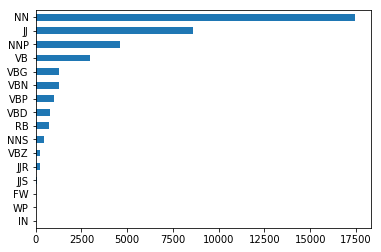

In [113]:
B.pos_max.value_counts().sort_values().plot.barh()

In [119]:
LIB_samp

,year,month,year_month,doc_title,doc_source
doc_id,,,,,
49,2013,11,2013-11,NY Times Editorial Board Hacked by The Onion,PowerLine
106,2013,11,2013-11,Putting 'rate shock' into perspective,Daily Kos
135,2013,11,2013-11,Daily Kos Elections Morning Digest: Minnesota ...,Daily Kos
432,2013,11,2013-11,Lies of Obamacare: Cancel this,PowerLine
1410,2013,11,2013-11,Elizabeth Warren joins expand Social Security ...,Daily Kos
...,...,...,...,...,...
1023311,2020,2,2020-02,Bernie All the Way? [Updated],PowerLine
1024310,2020,2,2020-02,"Bernie Sanders, 60 Minutes style",PowerLine
1024562,2020,2,2020-02,Good News On Immigration,PowerLine


In [122]:
B = B.reset_index()

In [125]:
B['year'] =  B.doc_id.map(LIB_samp.year)
B['month'] = B.doc_id.map(LIB_samp.month)
B['source'] = B.doc_id.map(LIB_samp.doc_source)
B['year_month'] = B.doc_id.map(LIB_samp.year_month)
B = B.set_index(['doc_id','term_id'])
B

n_x        tf     tfidf     term_str  term_rank    n_y  num  \
doc_id  term_id                                                                
49      1843       1  0.002849  0.006139  achievement     3908.0   21.0  0.0   
        3333       1  0.002849  0.003952     argument      854.0  115.0  0.0   
        5840       1  0.002849  0.006438       cancel     5640.0   12.0  0.0   
        7702       1  0.002849  0.005828    confusion     3378.0   25.0  0.0   
        7927       1  0.002849  0.003431     continue      697.0  137.0  0.0   
...              ...       ...       ...          ...        ...    ...  ...   
1026033 27905      1  0.002915  0.005318   revolution     2239.0   41.0  0.0   
        29852      1  0.002915  0.005159         sick     2165.0   43.0  0.0   
        32094      1  0.002915  0.006113  sympathetic     4389.0   17.0  0.0   
        36185      1  0.002915  0.003806         word      783.0  123.0  0.0   
        36190      1  0.002915  0.003001        words      414.0  224.0  0.0   

                pos_max  term_rank2         p  ...  negative  positive  \
doc_id  term_id                                ...                       
49      1843         NN       513.0  0.000569  ...       0.0       1.0   
        3333         NN       419.0  0.003116  ...       1.0       0.0   
        5840         VB       522.0  0.000325  ...       1.0       0.0   
        7702         NN       509.0  0.000677  ...       1.0       0.0   
        7927         VB       397.0  0.003712  ...       0.0       1.0   
...                 ...         ...       ...  ...       ...       ...   
1026033 27905       NNP       493.0  0.001111  ...       1.0       1.0   
        29852        JJ       491.0  0.001165  ...       1.0       0.0   
        32094        JJ       517.0  0.000461  ...       0.0       1.0   
        36185        NN       411.0  0.003333  ...       0.0       1.0   
        36190       NNS       317.0  0.006070  ...       1.0       0.0   

                  sadness  surprise     trust  polarity  year  month  \
doc_id  term_id                                                        
49      1843     0.000000  0.000000  0.006139  0.006139  2013     11   
        3333     0.000000  0.000000  0.000000 -0.003952  2013     11   
        5840     0.006438  0.000000  0.000000 -0.006438  2013     11   
        7702     0.000000  0.000000  0.000000 -0.005828  2013     11   
        7927     0.000000  0.000000  0.003431  0.003431  2013     11   
...                   ...       ...       ...       ...   ...    ...   
1026033 27905    0.005318  0.005318  0.000000  0.000000  2020      2   
        29852    0.005159  0.000000  0.000000 -0.005159  2020      2   
        32094    0.006113  0.000000  0.006113  0.006113  2020      2   
        36185    0.000000  0.000000  0.003806  0.003806  2020      2   
        36190    0.000000  0.000000  0.000000 -0.003001  2020      2   

                    source  year_month  
doc_id  term_id                         
49      1843     PowerLine     2013-11  
        3333     PowerLine     2013-11  
        5840     PowerLine     2013-11  
        7702     PowerLine     2013-11  
        7927     PowerLine     2013-11  
...                    ...         ...  
1026033 27905    PowerLine     2020-02  
        29852    PowerLine     2020-02  
        32094    PowerLine     2020-02  
        36185    PowerLine     2020-02  
        36190    PowerLine     2020-02  

[39753 rows x 26 columns]

In [129]:
EMO_year = B.groupby(['year'])[emo_cols].mean()
EMO_month = B.groupby(['month'])[emo_cols].mean()
EMO_source = B.groupby(['source'])[emo_cols].mean()
EMO_year_month = B.groupby(['year_month'])[emo_cols].mean()

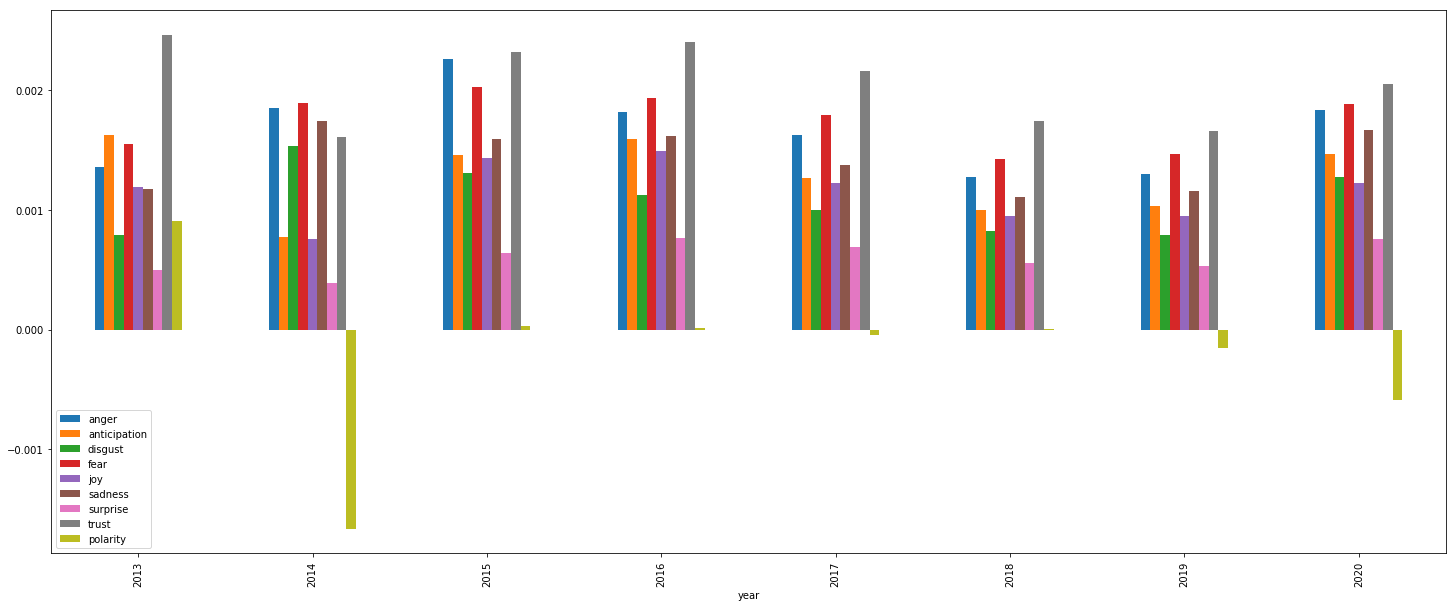

In [134]:
EMO_year.plot.bar(figsize=(25,10))

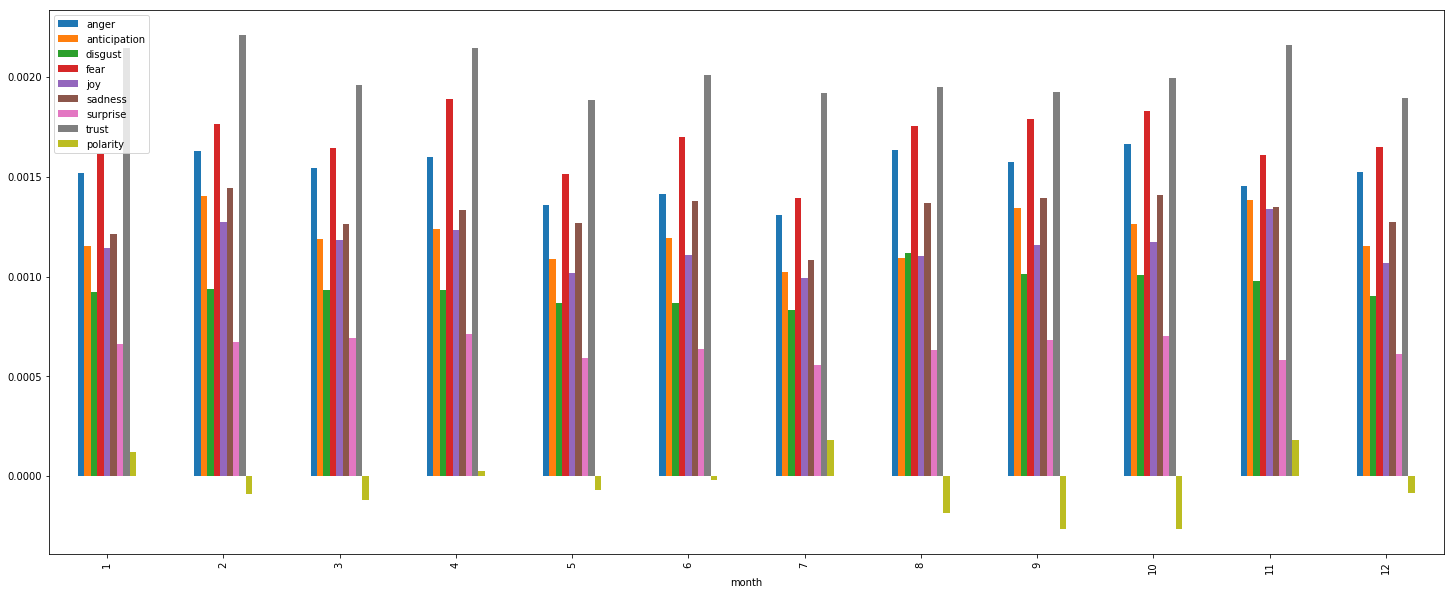

In [135]:
EMO_month.plot.bar(figsize=(25,10))

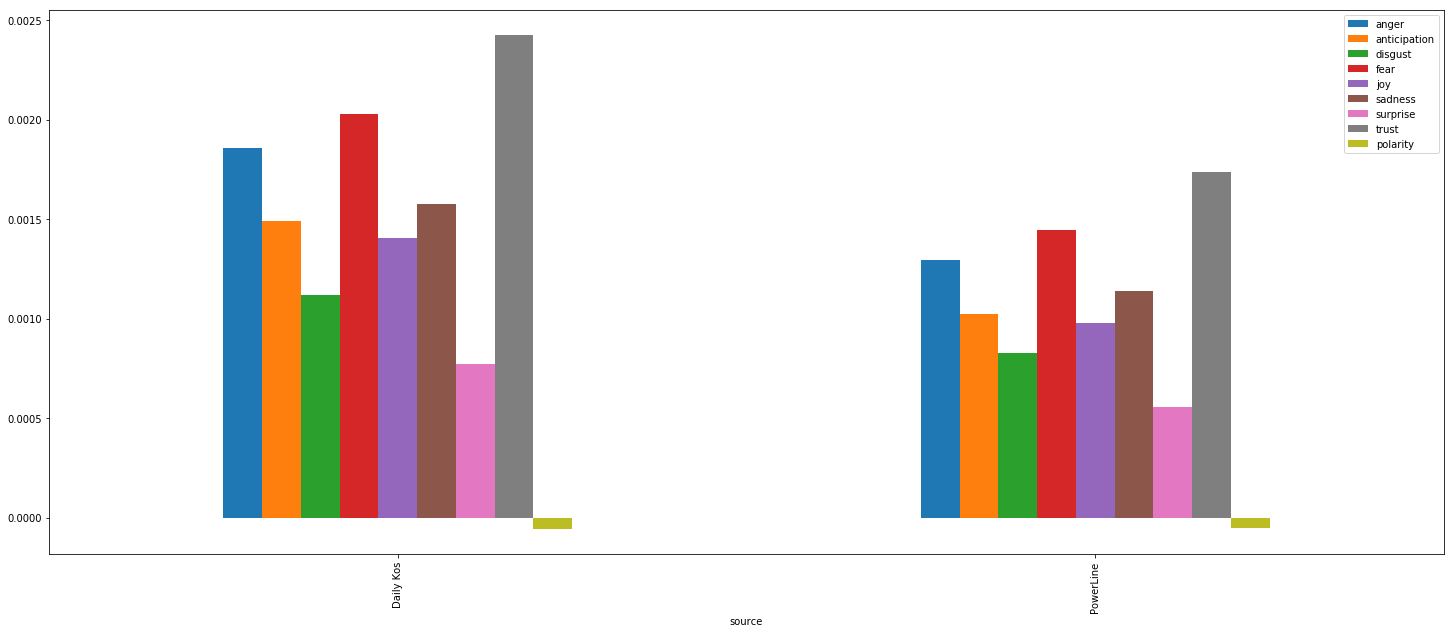

In [136]:
EMO_source.plot.bar(figsize=(25,10))

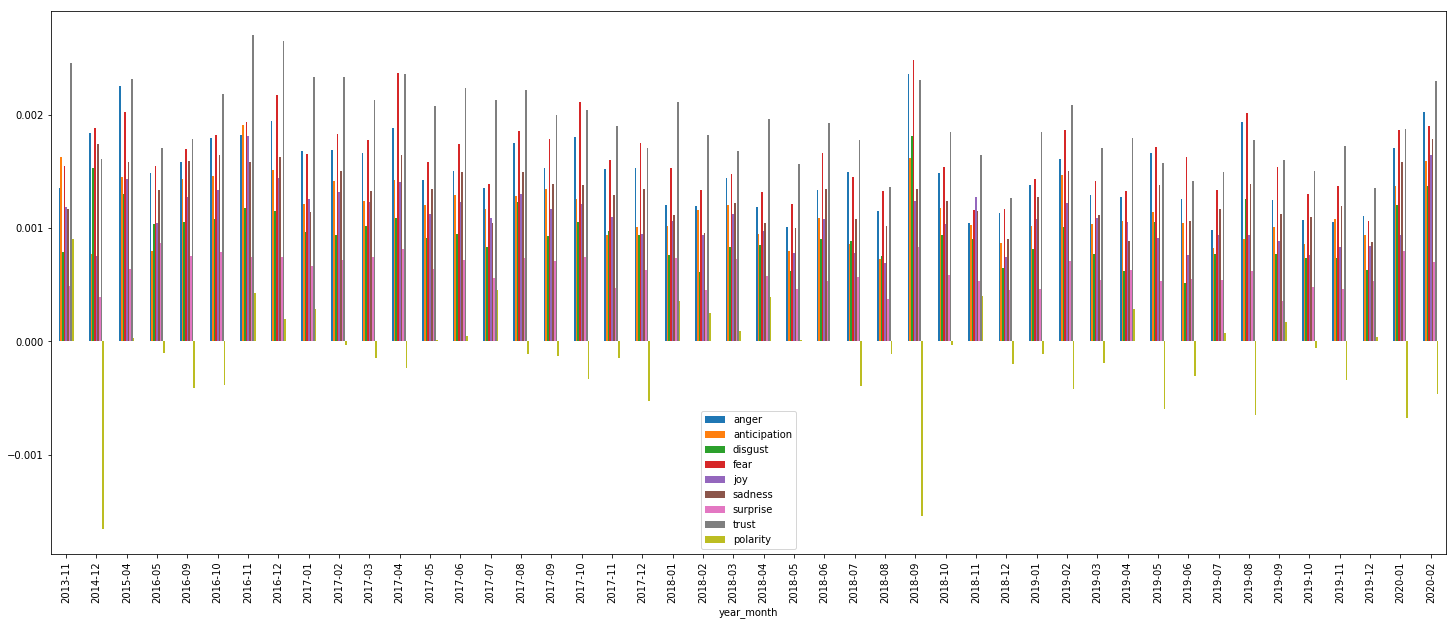

In [133]:
EMO_year_month.plot.bar(figsize=(25,10))

In [140]:
EMO_year_month.head()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,polarity
year_month,,,,,,,,,
2013-11,0.001356,0.001626,0.000788,0.001546,0.001191,0.001172,0.000493,0.002460,0.000902
2014-12,0.001845,0.000769,0.001529,0.001889,0.000754,0.001743,0.000389,0.001608,-0.001661
2015-04,0.002253,0.001452,0.001302,0.002023,0.001430,0.001586,0.000640,0.002317,0.000032
2016-05,0.001491,0.000800,0.001040,0.001549,0.001049,0.001341,0.000869,0.001707,-0.000099
2016-09,0.001585,0.001438,0.001059,0.001697,0.001280,0.001594,0.000756,0.001785,-0.000415


### Compare Texts

President Election happend Nov,8 2016. In order to compare the texts from the previous and preceding year, 2016-10, 2016-11, 2016-12, will be compared

In [144]:
ELECTION_OCT2016 = EMO_year_month.loc['2016-10'].copy()
ELECTION_NOV2016 = EMO_year_month.loc['2016-11'].copy()
ELECTION_DEC2016 = EMO_year_month.loc['2016-12'].copy()

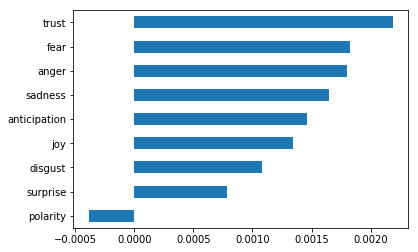

In [150]:
ELECTION_OCT2016.sort_values().plot.barh();

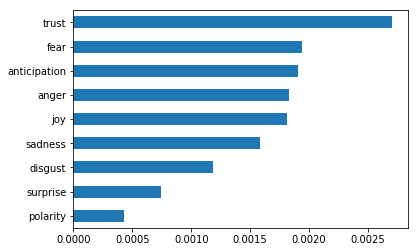

In [151]:
ELECTION_NOV2016.sort_values().plot.barh();

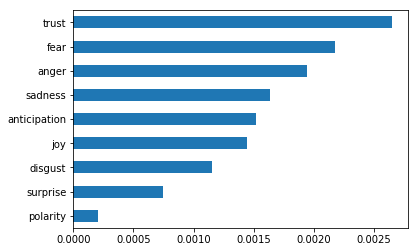

In [152]:
ELECTION_DEC2016.sort_values().plot.barh();

In [153]:
trust_words = pd.Series(SALEX[SALEX['trust'] == 1].index.tolist())

In [154]:
trust_words.sample(10)

819          succeed
537           magnet
402    grandchildren
627              pay
833       sweetheart
353         firmness
775          sensual
637          phalanx
867         tutelage
528         linguist
dtype: object

In [155]:
fear_words = pd.Series(SALEX[SALEX['fear'] == 1].index.tolist())
fear_words.sample(10)

847           obey
983         rascal
925        plunder
584        hanging
773           mace
48        anaconda
841       newcomer
230     compassion
105        badness
1074         seize
dtype: object

In [156]:
anger_words = pd.Series(SALEX[SALEX['anger'] == 1].index.tolist())
anger_words.sample(10)

337     disagreement
1037        sterling
700        malignant
1167      villainous
638      intolerance
1001       slaughter
691            lynch
114         betrayal
403            dumps
419         epidemic
dtype: object

### PowerLine vs. Daily Kos

In [162]:
B_group = B.groupby(['source','year_month']).mean()[emo_cols]

In [165]:
B_group

anger  anticipation   disgust      fear       joy  \
source    year_month                                                         
Daily Kos 2013-11     0.001497      0.001757  0.000858  0.001760  0.001064   
          2014-12     0.001845      0.000769  0.001529  0.001889  0.000754   
          2015-04     0.002253      0.001452  0.001302  0.002023  0.001430   
          2016-05     0.002253      0.001036  0.001684  0.002173  0.001651   
          2016-09     0.002201      0.001885  0.001436  0.002321  0.001531   
...                        ...           ...       ...       ...       ...   
PowerLine 2019-10     0.001074      0.000865  0.000735  0.001306  0.000763   
          2019-11     0.001053      0.001079  0.000737  0.001369  0.000838   
          2019-12     0.001111      0.000939  0.000628  0.001061  0.000843   
          2020-01     0.001709      0.001376  0.001202  0.001864  0.000937   
          2020-02     0.002026      0.001594  0.001370  0.001904  0.001644   

                       sadness  surprise     trust  polarity  
source    year_month                                          
Daily Kos 2013-11     0.001256  0.000462  0.002583  0.000830  
          2014-12     0.001743  0.000389  0.001608 -0.001661  
          2015-04     0.001586  0.000640  0.002317  0.000032  
          2016-05     0.001817  0.001185  0.002396 -0.000003  
          2016-09     0.002039  0.001001  0.002208 -0.000664  
...                        ...       ...       ...       ...  
PowerLine 2019-10     0.001102  0.000480  0.001507 -0.000056  
          2019-11     0.001194  0.000459  0.001725 -0.000342  
          2019-12     0.000882  0.000533  0.001355  0.000041  
          2020-01     0.001582  0.000797  0.001875 -0.000675  
          2020-02     0.001787  0.000699  0.002305 -0.000465  

[66 rows x 9 columns]

In [167]:
B_group_powerline = B_group.reset_index().loc[B_group.reset_index().source == 'PowerLine']
B_group_daily = B_group.reset_index().loc[B_group.reset_index().source == 'Daily Kos']

In [169]:
EMO_powerline = B_group_powerline.groupby(['year_month'])[emo_cols].mean()
EMO_daily = B_group_daily.groupby(['year_month'])[emo_cols].mean()

In [172]:
ELECTION_powerline_OCT2016 = EMO_powerline.loc['2016-10'].copy()
ELECTION_powerline_NOV2016 = EMO_powerline.loc['2016-11'].copy()
ELECTION_powerline_DEC2016 = EMO_powerline.loc['2016-12'].copy()

In [ ]:
powerline_date = B_group.loc['PowerLine']
daily_date = B_group.loc['Daily Kos']

In [ ]:
PERSUASION_chaps = EMO_CHAPS.loc[persuasion] 
MOBYDICK_chaps = EMO_CHAPS.loc[mobydick] 

In [183]:
EMO_powerline_thin = B_group.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("source == {}".format(['PowerLine']))
EMO_daily_thin= B_group.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("source == {}".format(['Daily Kos']))

In [ ]:
def plot_sentiments(df, emo='polarity'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

In [186]:
px.line(EMO_powerline_thin, x='year_month', y='value', color='emo')

In [185]:
px.line(EMO_daily_thin, x='year_month', y='value', color='emo')

## Word Embedding

In [220]:
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly_express as px

In [187]:
#remove stop words
VOCAB_samp = VOCAB_samp.loc[VOCAB_samp.stop == 0]

In [192]:
#remove stop words from TOKEN table
TOKEN_samp = TOKEN_samp.loc[TOKEN_samp.term_id.isin(VOCAB_samp.reset_index().term_id)]

In [194]:
powerline = LIB_samp.loc[LIB_samp.doc_source.str.contains('PowerLine')].reset_index().doc_id.to_list()
daily = LIB_samp.loc[LIB_samp.doc_source.str.contains('Daily')].reset_index().doc_id.to_list()

In [198]:
TOKEN_samp = TOKEN_samp.reset_index()

In [199]:
TOKEN_powerline = TOKEN_samp.loc[TOKEN_samp.doc_id.isin(powerline)]
TOKEN_daily= TOKEN_samp.loc[TOKEN_samp.doc_id.isin(daily)]

In [201]:
TOKEN_powerline['source'] = 'powerline'
TOKEN_daily['source'] = 'daily'

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [205]:
TOKEN_powerline['doc'] = TOKEN_powerline.doc_id.map(LIB_samp.reset_index().set_index('doc_id').doc_title)
TOKEN_daily['doc'] = TOKEN_daily.doc_id.map(LIB_samp.reset_index().set_index('doc_id').doc_title)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [211]:
TOKEN_powerline['year'] = TOKEN_powerline.doc_id.map(LIB_samp.year)
TOKEN_powerline['source'] = TOKEN_powerline.doc_id.map(LIB_samp.doc_source)
TOKEN_powerline['year_month'] = TOKEN_powerline.doc_id.map(LIB_samp.year_month)

TOKEN_daily['year'] = TOKEN_daily.doc_id.map(LIB_samp.year)
TOKEN_daily['source'] = TOKEN_daily.doc_id.map(LIB_samp.doc_source)
TOKEN_daily['year_month'] = TOKEN_daily.doc_id.map(LIB_samp.year_month)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [213]:
TOKEN_powerline.head()

,doc_id,sent_num,token_num,pos_tuple,pos,token_str,term_str,term_id,source,doc,year,year_month
0,49,0,1,"('John', 'NNP')",NNP,John,john,18003,PowerLine,NY Times Editorial Board Hacked by The Onion,2013,2013-11
1,49,0,2,"('Hinderaker', 'NNP')",NNP,Hinderaker,hinderaker,15789,PowerLine,NY Times Editorial Board Hacked by The Onion,2013,2013-11
2,49,0,5,"('least', 'JJS')",JJS,least,least,19057,PowerLine,NY Times Editorial Board Hacked by The Onion,2013,2013-11
3,49,0,7,"('think', 'VBP')",VBP,think,think,32840,PowerLine,NY Times Editorial Board Hacked by The Onion,2013,2013-11
4,49,0,11,"('Onion', 'NNP')",NNP,Onion,onion,23112,PowerLine,NY Times Editorial Board Hacked by The Onion,2013,2013-11


In [214]:
OHCO = ['doc', 'sent_num', 'token_num']
BAG = OHCO[:1] # document

In [215]:
TOKEN_powerline = TOKEN_powerline.set_index(OHCO)
TOKEN_daily = TOKEN_daily.set_index(OHCO)

In [216]:
 #remove proper noun, plural
corpus_powerline = TOKEN_powerline [~TOKEN_powerline .pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.astype(str).tolist())\
    .reset_index()['term_str'].tolist()

In [217]:
corpus_daily = TOKEN_daily[~TOKEN_daily.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

In [221]:
window = 5

In [222]:
model_powerline = word2vec.Word2Vec(corpus_powerline, size=246, window=window, min_count=200, workers=4)

In [223]:
model_daily = word2vec.Word2Vec(corpus_daily, size=246, window=window, min_count=200, workers=4)

In [224]:
coords_powerline = pd.DataFrame(index=range(len(model_powerline.wv.vocab)))
coords_powerline['label'] = [w for w in model_powerline.wv.vocab]
coords_powerline['vector'] = coords_powerline['label'].apply(lambda x: model_powerline.wv.get_vector(x))

In [225]:
coords_powerline.head()

,label,vector
0,could,"[0.10146337, -0.06255228, -0.124493405, -0.191..."
1,case,"[0.10702678, -0.06260904, -0.12774307, -0.1944..."
2,much,"[0.1007381, -0.06635124, -0.12703174, -0.19547..."
3,work,"[0.10153769, -0.06738504, -0.12718761, -0.1926..."
4,right,"[0.10057677, -0.06502356, -0.1265563, -0.19173..."


In [226]:
coords_daily = pd.DataFrame(index=range(len(model_daily.wv.vocab)))
coords_daily['label'] = [w for w in model_daily.wv.vocab]
coords_daily['vector'] = coords_daily['label'].apply(lambda x: model_daily.wv.get_vector(x))

In [227]:
coords_daily.head()

,label,vector
0,might,"[0.017634055, -0.17569585, -0.18106778, -0.226..."
1,say,"[0.018988684, -0.17314674, -0.17950791, -0.221..."
2,many,"[0.018678825, -0.17447601, -0.18209116, -0.228..."
3,one,"[0.021639267, -0.1764408, -0.1878934, -0.23269..."
4,election,"[0.021531593, -0.18101501, -0.18752779, -0.233..."


In [230]:
tsne_model_powerline = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_values_powerline = tsne_model_powerline.fit_transform(coords_powerline['vector'].tolist())

In [231]:
coords_powerline['x'] = tsne_values_powerline[:,0]
coords_powerline['y'] = tsne_values_powerline[:,1]

In [232]:
coords_powerline.head()

,label,vector,x,y
0,could,"[0.10146337, -0.06255228, -0.124493405, -0.191...",1.662498,4.575014
1,case,"[0.10702678, -0.06260904, -0.12774307, -0.1944...",5.450066,2.052593
2,much,"[0.1007381, -0.06635124, -0.12703174, -0.19547...",1.695435,2.562994
3,work,"[0.10153769, -0.06738504, -0.12718761, -0.1926...",1.797475,1.465928
4,right,"[0.10057677, -0.06502356, -0.1265563, -0.19173...",1.782254,4.865801


In [233]:
tsne_model_daily = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_values_daily = tsne_model_daily.fit_transform(coords_daily['vector'].tolist())

In [234]:
coords_daily['x'] = tsne_values_daily[:,0]
coords_daily['y'] = tsne_values_daily[:,1]

In [235]:
coords_daily.head()

,label,vector,x,y
0,might,"[0.017634055, -0.17569585, -0.18106778, -0.226...",-6.874725,0.873599
1,say,"[0.018988684, -0.17314674, -0.17950791, -0.221...",-8.346528,0.577762
2,many,"[0.018678825, -0.17447601, -0.18209116, -0.228...",-6.613724,0.862407
3,one,"[0.021639267, -0.1764408, -0.1878934, -0.23269...",-4.018065,0.782819
4,election,"[0.021531593, -0.18101501, -0.18752779, -0.233...",-3.564036,0.196800


In [238]:
px.scatter(coords_daily, 'x', 'y', text='label', height=1000).update_traces(mode='text')

## LDA Model

In [276]:
LIB = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/LIB.csv').set_index('doc_id')
DOC = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/DOC.csv').set_index(['doc_id','sent_num'])
TOKEN = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/TOKEN.csv').set_index(OHCO)
VOCAB = pd.read_csv('/Users/beautifulmonster/Desktop/DS5001/Final project/VOCAB.csv').set_index('term_id')

In [289]:
n_terms = 4000
n_topics = 10
max_iter = 5
OHCO = ['doc_id', 'sent_num']

In [290]:
from sklearn.feature_extraction.text import CountVectorizer #document-term matrix count
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [291]:
TOKEN.head()

token_num           pos_tuple  pos token_str term_str  \
doc_id sent_num                                                          
48     0                 0        ('I', 'PRP')  PRP         I        i   
       0                 2        ('ve', 'RB')   RB        ve       ve   
       0                 3     ('been', 'VBN')  VBN      been     been   
       0                 4  ('falling', 'VBG')  VBG   falling  falling   
       0                 5    ('behind', 'IN')   IN    behind   behind   

                 term_id  
doc_id sent_num           
48     0           52659  
       0          112857  
       0           16093  
       0           40567  
       0           16224

In [280]:
SENT = TOKEN[TOKEN.pos.str.match(r'^NNS?$')]\ ##pulling out nouns
        .groupby(OHCO)\
        .term_str.apply(lambda x: ' '.join(x.astype(str)))\
        .to_frame().rename(columns={'term_str':'sent_str'})

In [282]:
SENT.head()

sent_str
doc_id sent_num                                     
48     0                  features days subject wine
       1                                 catch guide
       2                                 timers name
       3                  family s vineyards century
       4         decades zinfandels region crop year

### Create Vector space

In [283]:
tfv = CountVectorizer(max_features=n_terms, stop_words='english')
tf = tfv.fit_transform(SENT.sent_str)
TERMS = tfv.get_feature_names()

### Generate Model

In [292]:
lda = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

**THETA**

In [293]:
THETA = pd.DataFrame(lda.fit_transform(tf), index=SENT.index)
THETA.columns.name = 'topic_id'

In [294]:
THETA.sample(20).style.background_gradient()

,topic_id,0,1,2,3,4,5,6,7,8,9
doc_id,sent_num,,,,,,,,,,
687268,35,0.020000,0.020003,0.020005,0.020001,0.020001,0.020001,0.020003,0.020002,0.020019,0.819965
292196,9,0.498829,0.014286,0.014295,0.014286,0.014287,0.014289,0.158607,0.014286,0.014287,0.242547
327576,4,0.699955,0.033338,0.033334,0.033338,0.033335,0.033336,0.033334,0.033354,0.033338,0.033337
290546,8,0.243211,0.490107,0.033336,0.033337,0.033340,0.033333,0.033336,0.033333,0.033333,0.033333
150830,9,0.033336,0.033350,0.033333,0.033344,0.033336,0.033335,0.033341,0.699955,0.033333,0.033335
299677,3,0.033334,0.033338,0.033336,0.033341,0.699941,0.033345,0.033346,0.033333,0.033338,0.033348
9318,19,0.050000,0.050004,0.050000,0.050000,0.050000,0.050004,0.050001,0.549976,0.050008,0.050006
242159,4,0.025011,0.025007,0.025003,0.025012,0.025005,0.025005,0.025012,0.774939,0.025002,0.025004
348128,4,0.050000,0.050001,0.549979,0.050003,0.050000,0.050001,0.050001,0.050000,0.050000,0.050014


**PHI**

In [295]:
PHI = pd.DataFrame(lda.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'
#phi table - language model

In [296]:
PHI.T.sample(20).style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9
term_str,,,,,,,,,,
shoulder,0.100006,0.353398,0.100001,0.149181,0.100012,56.797384,0.100005,0.100005,0.100006,0.100003
tariff,0.100010,41.963327,5.687782,0.100070,0.100851,0.101435,0.100012,0.640576,0.100005,3.105932
plastic,0.100028,17.468153,0.100004,0.100011,0.100032,12.070861,0.101006,0.100052,0.100070,34.759784
sheriff,11.745515,0.310032,10.314571,0.100007,16.251179,0.100145,0.100012,0.713926,124.264379,0.100234
certificate,0.223048,0.803149,0.100007,0.100010,5.992172,0.100109,0.100008,6.427165,50.699380,33.454951
trends,0.100022,39.088604,0.100006,0.721895,1.183689,31.351698,0.100023,62.656138,0.437234,0.260691
intimidation,75.889405,6.807382,0.159662,6.385715,0.412638,10.778952,0.300524,0.264217,18.265895,0.735609
churches,2.012172,56.318501,0.712273,10.529285,0.100019,0.100008,0.100006,0.100010,1.816373,10.211353
species,0.100004,0.147187,4.336627,0.323285,0.101050,39.115197,0.389843,0.209174,88.928180,5.349453


### Inspect Result 
#### Get Terms per Topic

In [297]:
TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

In [298]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8,9
topic_id,,,,,,,,,,
0,state,country,question,tax,women,case,candidates,media,statement,war
1,voters,work,investigation,years,person,end,nation,company,book,family
2,thing,law,reason,states,case,information,decision,position,time,issue
3,president,things,vote,day,evidence,members,team,right,idea,government
4,people,news,days,man,police,video,media,reporters,week,time
5,race,point,politics,left,article,record,sense,words,isn,data
6,percent,people,health,campaign,care,plan,insurance,lot,fact,coverage
7,year,week,press,course,students,school,job,problem,night,money
8,time,way,election,years,power,candidate,administration,immigration,immigrants,matter


In [299]:
TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ' '.join(x), 1)

### Sort Topic By DOC weight

In [300]:
TOPICS['doc_weight_sum'] = THETA.sum()

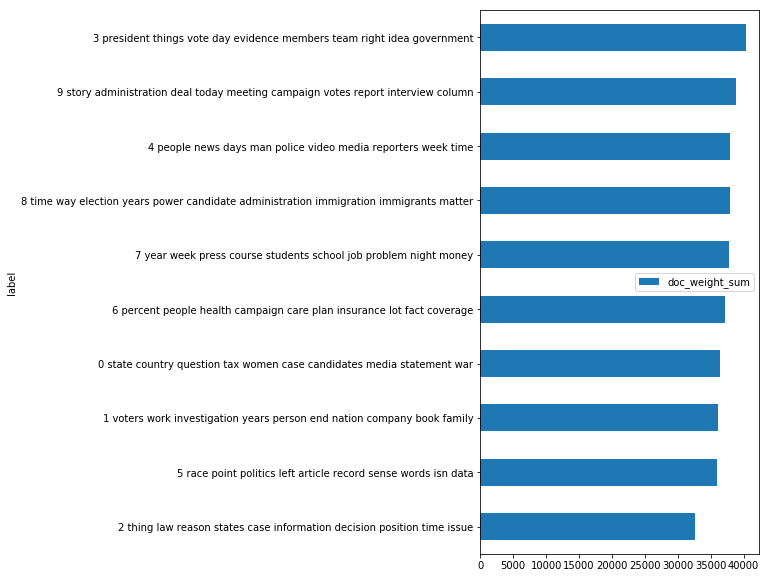

In [301]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,10))

### Explore Topic by Source

In [302]:
topic_cols = [t for t in range(n_topics)]
SOURCE = THETA.join(LIB, on='doc_id')\
    .reset_index().set_index(['doc_source']+OHCO)\
    .groupby('doc_source')[topic_cols].mean()\
    .T                                            
SOURCE.index.name = 'topic_id'

In [303]:
SOURCE['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)

In [304]:
SOURCE.sort_values('Daily Kos', ascending=False).style.background_gradient()

doc_source,Daily Kos,PowerLine,topterms
topic_id,,,
6,0.121403,0.083560,percent people health campaign care plan insurance lot fact coverage
3,0.108553,0.108865,president things vote day evidence members team right idea government
0,0.104647,0.093220,state country question tax women case candidates media statement war
8,0.104432,0.100332,time way election years power candidate administration immigration immigrants matter
1,0.099906,0.095299,voters work investigation years person end nation company book family
4,0.099528,0.104413,people news days man police video media reporters week time
7,0.098205,0.104737,year week press course students school job problem night money
9,0.091860,0.114530,story administration deal today meeting campaign votes report interview column
2,0.088798,0.087305,thing law reason states case information decision position time issue


In [305]:
SOURCE.sort_values('PowerLine', ascending=False).style.background_gradient()

doc_source,Daily Kos,PowerLine,topterms
topic_id,,,
9,0.091860,0.114530,story administration deal today meeting campaign votes report interview column
3,0.108553,0.108865,president things vote day evidence members team right idea government
5,0.082668,0.107738,race point politics left article record sense words isn data
7,0.098205,0.104737,year week press course students school job problem night money
4,0.099528,0.104413,people news days man police video media reporters week time
8,0.104432,0.100332,time way election years power candidate administration immigration immigrants matter
1,0.099906,0.095299,voters work investigation years person end nation company book family
0,0.104647,0.093220,state country question tax women case candidates media statement war
2,0.088798,0.087305,thing law reason states case information decision position time issue


In [306]:
px.scatter(SOURCE.reset_index(), 'Daily Kos', 'PowerLine', hover_name='topterms', text='topic_id')\
    .update_traces(mode='text')

### Cluster Topic

In [307]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [316]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(5, 10))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=14)

In [317]:
SIMS = pdist(normalize(PHI), metric='euclidean')
TREE = sch.linkage(SIMS, method='ward')

In [318]:
labels  = ["{}: {}".format(a,b) for a, b in zip(SOURCE.index,  SOURCE.topterms.tolist())]

<Figure size 432x288 with 0 Axes>

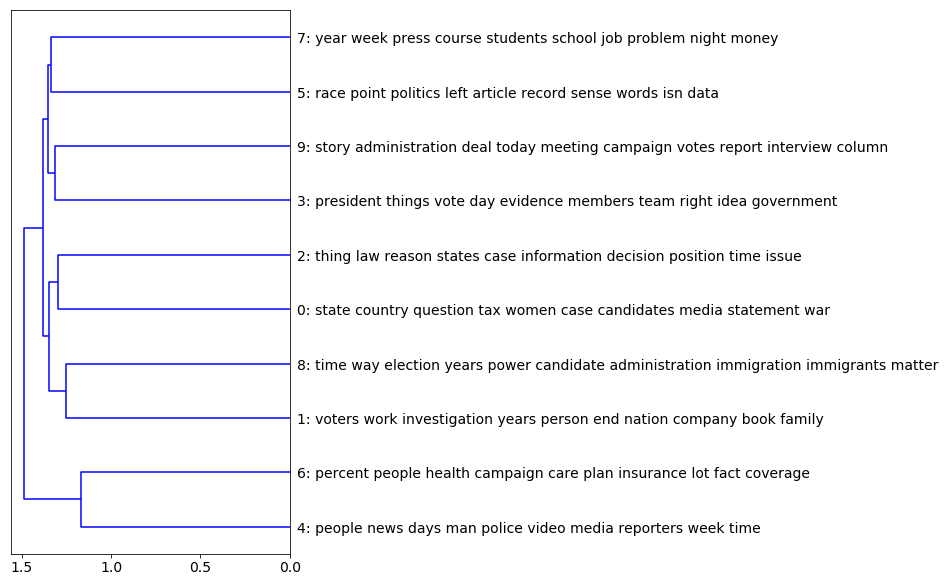

In [319]:
plot_tree(TREE, labels)

In [320]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [321]:
pyLDAvis.sklearn.prepare(lda, tf, tfv)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.120597  0.113904       1        1  10.968178
3     -0.083444 -0.175075       2        1  10.649168
9     -0.122164 -0.145917       3        1  10.442072
8      0.012585 -0.011959       4        1  10.368556
4     -0.178111  0.041756       5        1  10.116157
1      0.055067  0.071359       6        1   9.809163
7     -0.110714  0.100884       7        1   9.719849
0      0.154538  0.088307       8        1   9.564476
5     -0.044173  0.119534       9        1   9.421754
2      0.195818 -0.202793      10        1   8.940626, topic_info=           Term          Freq         Total Category  logprob  loglift
2580     people  15994.000000  15994.000000  Default  30.0000  30.0000
2743  president   8137.000000   8137.000000  Default  29.0000  29.0000
2582    percent   5960.000000   5960.000000  Default  28.0000  28.0000
2369       news   5173.000000   5173.000000  Default  27.0000  27.0000
1213   election   6662.000000   6662.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
870       court   1149.372847   2845.311915  Topic10  -4.6965   1.5081
2683      polls    738.005469   1097.690733  Topic10  -5.1395   2.0176
3665       time   1504.387626  11040.173902  Topic10  -4.4273   0.4214
3428      state   1005.533892   8435.178238  Topic10  -4.8302   0.2877
2057     letter    821.810824   1930.225585  Topic10  -5.0320   1.5607

[719 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1        10  0.998030        326
2        10  0.998030        580
23        1  0.005423    account
23        2  0.925449    account
23        3  0.001808    account
...     ...       ...        ...
3995      6  0.118848  yesterday
3995      7  0.082951  yesterday
3995      8  0.026680  yesterday
3995      9  0.024255  yesterday
3995     10  0.043658  yesterday

[3283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 10, 9, 5, 2, 8, 1, 6, 3])

## VOCAB entropy

In [63]:
count_method = 'n' # 'c' or 'n' # n = n tokens, c = distinct token (term) count
tf_method = 'sum' # sum, max, log, double_norm, raw, binary
tf_norm_k = .5 # only used for double_norm
idf_method = 'standard' # standard, max, smooth
gradient_cmap = 'YlGnBu' 

In [51]:
VOCAB['p2'] = VOCAB.n / VOCAB.n.sum()

In [52]:
VOCAB['h'] = VOCAB.p2 * np.log2(1/VOCAB.p2) # Self entropy of each word 
H = VOCAB.h.sum()
N_v = VOCAB.shape[0]
H_max = np.log2(N_v)
R = round(1 - (H/H_max), 2) * 100

In [57]:
bag = ['doc_id']

In [73]:
BOW_jj = TOKEN_jj.groupby(bag+['term_id']).term_id.count()\
    .to_frame().rename(columns={'term_id':'n'})

In [61]:
BOW['c'] = BOW.n.astype('bool').astype('int')

In [72]:
TOKEN_jj = TOKEN.loc[TOKEN.pos == 'JJ']

In [75]:
DTCM = BOW_jj[count_method].unstack().fillna(0).astype('int')